<h1> How can smart sampling accelerate the prediction of the spinodal for a system undergoing liquid liquid phase separation?</h1>
<p> Mean field theory based on this paper: https://pubs.acs.org/doi/pdf/10.1021/acs.jpcb.0c00402 </p>

<p> Suppose that experimental data were costly, and it was desirable to minimise the amount of experimental data needed to predict the spinodal of a two component mixture in composition space. One could of course sample random points in two dimensional composition space, observe what phase each point corresponded to, and reapeat. But there might be a more efficient method. A candidate alternative would be to use active machine learning -- that is to train a model on a small set of datapoints, then request data concerning the compositions the model is least able to predict. Typically, we might expect those points to lie fairly close to the decision boundary of a classifier -- i.e the spinodal of the two component mixture. 
    
This active learning process could then be iterated:</p>

<p> 
    
1. The model is fitted
    
1. The model tells the experimenter where it is least certain
    
1. The experimenter provides new points, chosen from the location in composition space where the model would be helped the most.
</p>

<p> I've hacked together a super simple demonstration of this, based on using an analytically solvable phase diagram for LLPS, with a Random Forest Classifier being the ML model which undergoes active learning.</p>

The analytical model is based on the paper  "Simple Calculation of Phase Diagrams for Liquid−Liquid Phase
Separation in Solutions of Two Macromolecular Solute Species" (Allen P. Minton, 2020, The Journal of Physical Chemistry B). I'm not sure if the parameters I have chosen are reasonable for mixture components, but I've just chosen parameters which qualitatively reproduce experimentally observed phase diagrams for LLPS.

<h2> Calculating the true phase diagram </h2>

(0.0, 1.0)

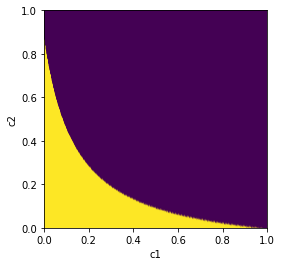

In [3]:
#parameters related to pairwise interaction potentials
#there aren't any units here for anything -- I just want a qualitative phase diagram...

B11 = -1
B12 = 3
B22 = -1
B111 = 0
B112 = 0
B122 = 0
B222 = 0

def get_log_gamma2_by_c2(c1,c2):
    return B22 + 2*B122*c1+2*B222*c2
def get_log_gamma1_by_c1(c1,c2):
    return B11 + 2*B111*c1+2*B112*c2
def get_log_gamma1_by_c2(c1,c2):
    return B12+2*B112*c1+2*B122*c2

def get_phase(c1,c2):
    x = ((1+c2*get_log_gamma2_by_c2(c1,c2))*(1+c1*get_log_gamma1_by_c1(c1,c2)) - 
            c1*c2*(get_log_gamma1_by_c2(c1,c2))**2)
    return x > 0

import numpy as np

c1_array = np.linspace(0,1,300)
c2_array = np.linspace(0,1,300)

x = []
y = []
phase = []

for c1 in c1_array:
    for c2 in c2_array:
        x.append(c1); y.append(c2); phase.append(get_phase(c1,c2))

import matplotlib.pyplot as plt
%matplotlib inline

#phase boundary
f,ax = plt.subplots(1,1,figsize = (4,4))
plt.scatter(x,y,c = phase)
ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

<p> Now we have an approximate phase diagram, let's sample some points so we can train a classifier </p>

In [19]:
x = []
y = []
phase = []

for i in range(2000):

    c1 = np.random.rand()
    c2 = np.random.rand()
    p = get_phase(c1,c2)
    x.append(c1)
    y.append(c2)
    phase.append(p)

<h2> Plotting the decision boundaries of a Random Forest trained to reproduce the training data </h2>

Text(0, 0.5, 'c2')

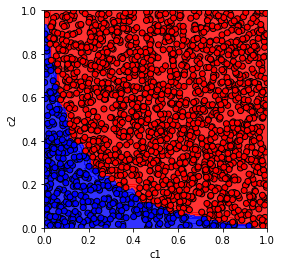

In [22]:
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

X = np.array(list(zip(x,y)))

clf.fit(X, phase) #training the random forest classifier

xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)


f,ax = plt.subplots(1,1,figsize = (4,4))
ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

ax.scatter(X[:, 0], X[:, 1], c=phase, cmap=cm_bright,
                   edgecolors='k')

ax.set_xlabel('c1')
ax.set_ylabel('c2')

<p> Our points are plotted above, along with the decision function as a background. We seem to be predicting well if have a very large number of points. Now let's look at how our decision function changes with number of queried points if we use active learning. </p>

<h2> Using a greedy Active Learning approach </h2>

<p> In this very simple approach, I will initially look at the four corners of the composition space to get a very primative phase diagram. Then I will sequentially ask the model where it is most unsure -- i.e. where in configuration space is the class prediction probability closest to 0.5? Then we will look at this point, add it to the training dataset and repeat. </p>

Text(0, 0.5, 'c2')

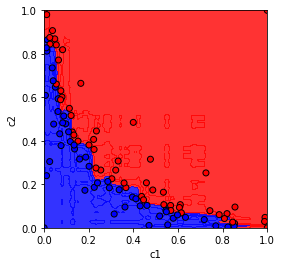

In [23]:

clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

for _ in range(100):
    clf.fit(X_ours, phase_ours)

    sample = X[np.argmin(np.abs(clf.predict_proba(X)[:,0]-0.5))] 

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))

f,ax = plt.subplots(1,1,figsize = (4,4))

X_ours = np.array(X_ours)

xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)


ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                   edgecolors='k')


ax.set_xlabel('c1')
ax.set_ylabel('c2')

<p> Notice how the points we query now are all very close to the decision boundary. These are the points the classifier is least sure about, so when the target class is revealed, they result in the biggest increase in information. </p>

<h1> Decision boundary as number of samples change for (greedy) active learning system </h1>

<p> It would be useful to see this active learning in action -- here I have trained similarly to above, but every 10 points added, the decision function and known points are plotted. Notice how even after just 43 points, the decision function has already converged. I have also written the accuracy of the classifier on points uniformly chosen from configuration space. Due to the imbalance of the classes (i.e. fewer non-phase-separated observations), this isn't an amazing measure of classifier performance. </p> 

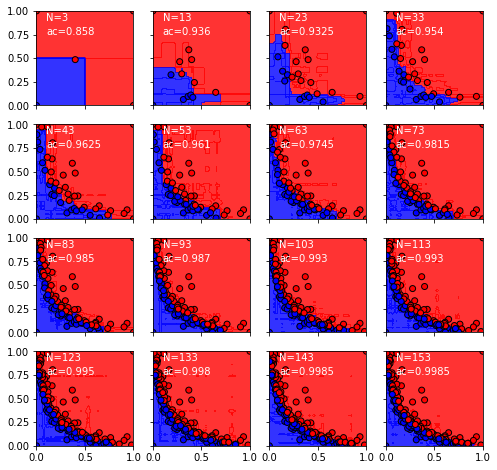

In [25]:
f,ax = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

ac_active = []
N_active = []

for _ in range(160):

    clf.fit(X_ours, phase_ours)

    sample = X[np.argmin(np.abs(clf.predict_proba(X)[:,0]-0.5))] 

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))
    
    if _%10 == 0:
        
        our_ax = ax.flatten()[int(_/10)]

        X_ours = np.array(X_ours)

        xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                                 np.linspace(0, 1, 100))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)


        our_ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

        our_ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                           edgecolors='k')

        predictions = clf.predict_proba(X)[:,0]
        binary_prediction = 1-np.array(list(map(int,predictions + 0.5)))
        accuracy = np.sum(binary_prediction == phase )/ float(len(phase))
        our_ax.text(0.1,0.9,f"N={_+3}",color = 'w')
        our_ax.text(0.1,0.75,f"ac={accuracy}",color = 'w')
        
        ac_active.append(accuracy)
        N_active.append(_+3)
        
    X_ours = list(X_ours)

<h1> Decision boundary as number of samples change for naive random point system </h1>

<p> Let's compare this active learning approach to a more conventional system where we just randomly sample points in composition space. Notice that in this case, lots of points are 'wasted' in regions of the composition space, where the decision function is already sure.</p>

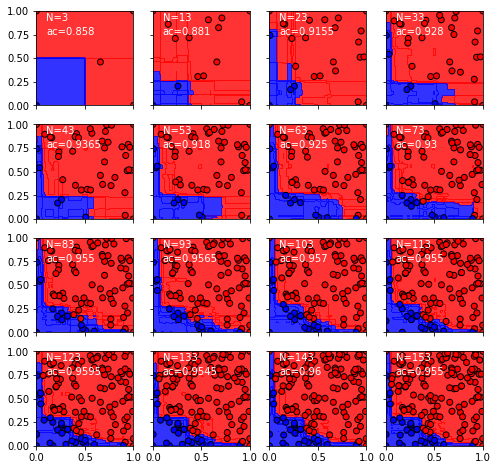

In [26]:
f,ax = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

ac_random = []
N_random = []

for _ in range(160):

    clf.fit(X_ours, phase_ours)

    sample = [np.random.rand(),np.random.rand()]

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))
    
    if _%10 == 0:
        
        our_ax = ax.flatten()[int(_/10)]

        X_ours = np.array(X_ours)

        xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                                 np.linspace(0, 1, 100))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)


        our_ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

        our_ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                           edgecolors='k')
        
        
        
        predictions = clf.predict_proba(X)[:,0]
        binary_prediction = 1-np.array(list(map(int,predictions + 0.5)))
        accuracy = np.sum(binary_prediction == phase )/ float(len(phase))
        our_ax.text(0.1,0.9,f"N={_+3}",color = 'w')
        our_ax.text(0.1,0.75,f"ac={accuracy}",color = 'w')
        
        ac_random.append(accuracy)
        N_random.append(_+3)
        
    X_ours = list(X_ours)

<h1> A simple comparison of accuracy scaling for active learning vs random sampling </h1>

<p> Obviously the active learning system massively outperforms the random sampling system. Below is an illustration. </p>

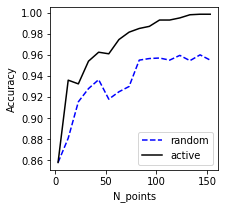

In [28]:
f,ax = plt.subplots(1,1,figsize = (3,3))

plt.plot(N_random,ac_random,'b--',label = "random")
plt.plot(N_active,ac_active,'k-',label = 'active')

plt.xlabel('N_points')
plt.ylabel('Accuracy')

plt.legend()

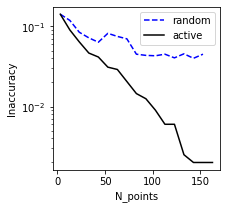

In [35]:
f,ax = plt.subplots(1,1,figsize = (3,3))

ac_random = np.array(ac_random)
ac_active = np.array(ac_active)

plt.plot(N_random,1-ac_random,'b--',label = "random")
plt.plot(N_active,1-ac_active,'k-',label = 'active')

plt.xlabel('N_points')
plt.ylabel('Inaccuracy')

ax.set_yscale('log')

plt.legend()

<p> One obvious final note -- I have retrained the model offline for each additional point. This is fabulously inefficient when the number of datapoints becomes large. We would use online learning in real life, but not sure how to work that into sklearn... </p> 